In [1]:
from pca_dataflow_V3_variables import *

In [2]:
# Check if files exist
if os.path.exists(file):
    print(f"File exists: {file}")
else:
    print(f"File not found: {file}")

if os.path.exists(hdr_file):
    print(f"HDR File exists: {hdr_file}")
else:
    print(f"HDR File not found: {hdr_file}")

File exists: ../aviris_data/e_done/e_ang20180722t212222rfl/data/hs_raw_image\ang20180722t212222_rfl_v2r2_img
HDR File exists: ../aviris_data/e_done/e_ang20180722t212222rfl/data/hs_raw_image\ang20180722t212222_rfl_v2r2_img.hdr


In [3]:
# open the hyperspectral image file with GDAL
img_open = gdal.Open(file)

c:\Users\patri\anaconda3\envs\my_thesis_env\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [4]:
# read a few key properties of the image
nbands = img_open.RasterCount
ncols = img_open.RasterXSize
nrows = img_open.RasterYSize

print("\n".join(["Bands:\t"+str(nbands),"Cols (RasterXSize):\t"+str(ncols),"Rows (RasterYSize):\t"+str(nrows)]))

Bands:	425
Cols (RasterXSize):	689
Rows (RasterYSize):	17913


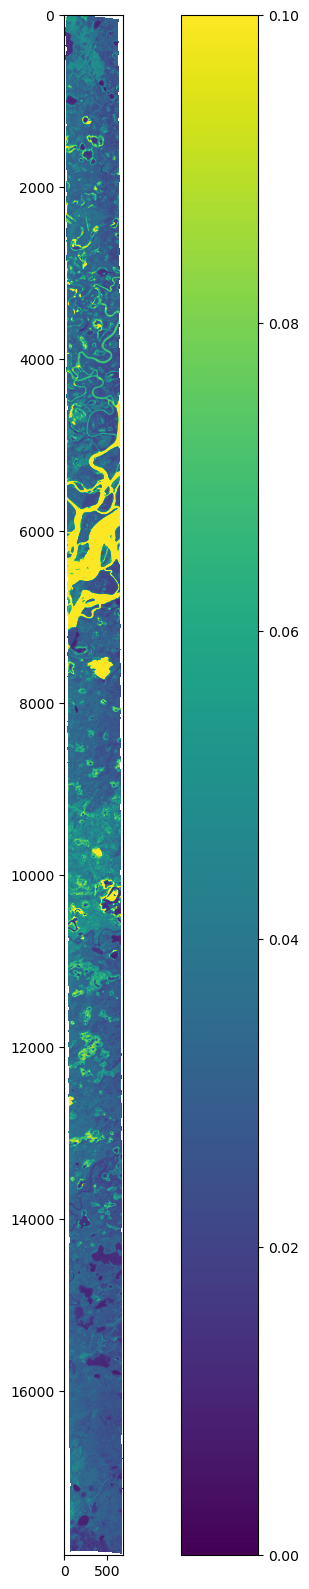

In [5]:
# read and display band 57 just to have a quick look at the image
img_red = img_open.GetRasterBand(57).ReadAsArray()
img_red = np.where(img_red == -9999, np.nan, img_red)
plt.rcParams["figure.figsize"] = [15,20]
plt.rcParams["figure.dpi"] = 100
plt.imshow(img_red,vmin=0, vmax=0.1)
plt.colorbar()
plt.show()

In [6]:
# Define NoData value
nodata_value = -9999

# Extract the required bands (band 57, 34, and 20)
band_57 = img_open.GetRasterBand(57).ReadAsArray()
band_34 = img_open.GetRasterBand(34).ReadAsArray()
band_20 = img_open.GetRasterBand(20).ReadAsArray()

# Replace NoData values with NaN (or any other appropriate value)
# set fill values (-9999.) to 0 for each array
band_57[band_57 == nodata_value], band_34[band_34 == nodata_value], band_20[band_20 == nodata_value] = 0, 0, 0

# function scales reflectance values to 8bits
scale8bit = lambda a: ((a - a.min()) * (1/(a.max() - a.min()) * 255)).astype('uint8')

# get 8bit arrays for each band
band_57_8bit, band_34_8bit, band_20_8bit = scale8bit(band_57), scale8bit(band_34), scale8bit(band_20)

# set rescaled fill pixels back to 0 for each array
band_57_8bit[band_57 == 0], band_34_8bit[band_34 == 0], band_20_8bit[band_20 == 0] = 0, 0, 0

# c ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# make rgb stack
rgb_stack = np.zeros((nrows,ncols,3),'uint8')
rgb_stack[...,0], rgb_stack[...,1], rgb_stack[...,2] = band_57_8bit, band_34_8bit, band_20_8bit

# Rearrange to (RasterCount, RasterYSize, RasterXSize)
reordered_rgb_stack = np.transpose(rgb_stack, (2, 0, 1))

In [7]:
# Define output file path
RGB_file = os.path.join(input_dir, "output_rgb_image.tif")

# Save the RGB image as a GeoTIFF
save_array(RGB_file, reordered_rgb_stack,reordered_rgb_stack.shape[0], img_open,"GTiff",0,gdal.GDT_Byte)

print(f"RGB image saved as {RGB_file}")

RGB image saved as ../aviris_data/e_done/e_ang20180722t212222rfl/data/hs_raw_image\output_rgb_image.tif


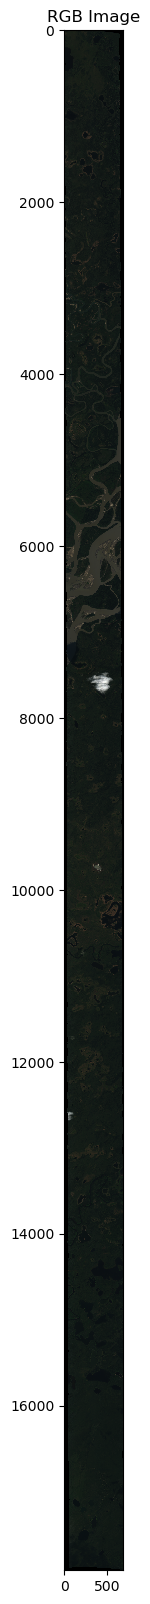

In [8]:
plt.figure(figsize=(15, 20))
plt.imshow(rgb_stack, cmap='bwr', interpolation='none')
plt.title('RGB Image')
plt.show()

In [9]:
del band_57, band_34, band_20, band_57_8bit, band_34_8bit, band_20_8bit, rgb_stack
gc.collect()

7973

# Calculate SAVI

In [10]:
# Define band ranges for NIR, Green, and Red
nir_bands = range(86, 106)  # Bands 86 to 105 (1-based indexing in GDAL)
green_bands = range(26, 46)  # Bands 26 to 45
red_bands = range(56, 66)    # Bands 56 to 65


# Calculate averages for each range
nir_average = calculate_band_average(img_open, nir_bands)
green_average = calculate_band_average(img_open, green_bands)
red_average = calculate_band_average(img_open, red_bands)

c:\Users\patri\Documents\GitHub\UWW200_Master_Thesis_public\MasterThesisPythonCode\pca_dataflow_V3_variables.py:66: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.stack(band_arrays, axis=0), axis=0)


In [11]:
# Define SAVI parameters
SAVI_L = 0.5  # Adjust this based on your requirements
SAVI_threshold = 0.2  # Example threshold for vegetation identification

# Calculate the SAVI
SAVI = ((nir_average - red_average) * (1 + SAVI_L)) / (nir_average + red_average + SAVI_L)

# Create a SAVI mask
savi_mask = np.where(SAVI > SAVI_threshold, 1, np.nan)

# Set value 0 to NaN to exclude unwanted pixels
#savi_mask = np.where(savi_mask == 0, np.nan, 1)

# Save SAVI and savi_mask

# ENVI format
SAVI_file_envi = os.path.join(input_dir, "SAVI")
SAVI_mask_file_envi = os.path.join(input_dir, "SAVI_mask")
save_array(SAVI_file_envi, SAVI, 1, img_open,"ENVI")
save_array(SAVI_mask_file_envi, savi_mask, 1, img_open,"ENVI")

#Geotiff format
SAVI_file = os.path.join(input_dir, "SAVI.tif")
SAVI_mask_file = os.path.join(input_dir, "SAVI_mask.tif")
save_array(SAVI_file, SAVI, 1, img_open,"GTiff")
save_array(SAVI_mask_file, savi_mask, 1, img_open,"GTiff")

print(f'SAVI mask saved as GTiff {SAVI_mask_file}')
print(f'SAVI mask saved as ENVI {SAVI_mask_file_envi}')
print(f'SAVI saved as GTiff {SAVI_mask_file}')
print(f'SAVI saved as ENVI {SAVI_file_envi}')

SAVI mask saved as GTiff ../aviris_data/e_done/e_ang20180722t212222rfl/data/hs_raw_image\SAVI_mask.tif
SAVI mask saved as ENVI ../aviris_data/e_done/e_ang20180722t212222rfl/data/hs_raw_image\SAVI_mask
SAVI saved as GTiff ../aviris_data/e_done/e_ang20180722t212222rfl/data/hs_raw_image\SAVI_mask.tif
SAVI saved as ENVI ../aviris_data/e_done/e_ang20180722t212222rfl/data/hs_raw_image\SAVI


# Calculate NDWI

In [12]:
# Formula: NDWI = (Green – NIR)/(Green + NIR)

# Define NDWI parameters
# The NDWI values correspond to the following ranges:
# 0,2 – 1 – Water surface,
# 0.0 – 0,2 – Flooding, humidity,
# -0,3 – 0.0 – Moderate drought, non-aqueous surfaces,
# -1 – -0.3 – Drought, non-aqueous surfaces

NDWI_threshold = 0.2

# Calculate the SAVI
NDWI = (green_average - nir_average)/(green_average + nir_average)

# Create a SAVI mask
ndwi_mask = np.where(NDWI > NDWI_threshold, 1, np.nan)

# Set value 0 to NaN to exclude unwanted pixels
ndwi_mask = np.where(ndwi_mask == 0, np.nan, ndwi_mask)

# Save NDWI and ndwi_mask

# ENVI format
NDWI_file_envi = os.path.join(input_dir, "NDWI")
NDWI_mask_file_envi = os.path.join(input_dir, "NDWI_mask")
save_array(NDWI_file_envi, NDWI, 1, img_open,"ENVI")
save_array(NDWI_mask_file_envi, ndwi_mask, 1, img_open,"ENVI")

#Geotiff format
NDWI_file = os.path.join(input_dir, "NDWI.tif")
NDWI_mask_file = os.path.join(input_dir, "NDWI_mask.tif")
save_array(NDWI_file, NDWI, 1, img_open,"GTiff")
save_array(NDWI_mask_file, ndwi_mask, 1, img_open,"GTiff")

print(f'NDWI mask saved as GTiff {NDWI_mask_file}')
print(f'NDWI mask saved as ENVI {NDWI_mask_file_envi}')
print(f'NDWI saved as GTiff {NDWI_file}')
print(f'NDWI saved as ENVI {NDWI_file_envi}')

NDWI mask saved as GTiff ../aviris_data/e_done/e_ang20180722t212222rfl/data/hs_raw_image\NDWI_mask.tif
NDWI mask saved as ENVI ../aviris_data/e_done/e_ang20180722t212222rfl/data/hs_raw_image\NDWI_mask
NDWI saved as GTiff ../aviris_data/e_done/e_ang20180722t212222rfl/data/hs_raw_image\NDWI.tif
NDWI saved as ENVI ../aviris_data/e_done/e_ang20180722t212222rfl/data/hs_raw_image\NDWI


In [13]:
del nir_bands, green_bands, red_bands, nir_average, green_average, red_average
gc.collect()

0

# Perform PCA

In [14]:
# File path
pca_model_file = os.path.join(input_dir, "pca_model.pkl")
pca_result_file = os.path.join(input_dir, "pca_result.npz")
pc_number_file = os.path.join(input_dir, "Selected_Components.txt")

In [15]:
perform_pca = True

if(perform_pca):
    # Load the SAVI mask
    savi_mask_ds = gdal.Open(SAVI_mask_file)
    savi_mask = savi_mask_ds.GetRasterBand(1).ReadAsArray()
    savi_mask = np.where(savi_mask == 1, 1, np.nan)  # Keep only 1s, set others to NaN

    # Prepare hyperspectral image data
    bands = img_open.RasterCount  # Number of bands in the image
    rows, cols = savi_mask.shape

    # Initialize an empty list to store valid pixel data
    valid_pixels = []

    # Define the bands to include based on bblist
    bblist = np.ones((425,))
    bblist[0:14] = 0
    bblist[189:225] = 0
    bblist[281:336] = 0
    bblist[405:] = 0

    # Convert bblist to boolean mask for included bands
    included_bands = np.where(bblist == 1)[0] + 1  # GDAL bands are 1-based
    num_included_bands = len(included_bands)

    # Loop through only the included bands
    valid_pixels = []
    for band_index in included_bands:
        band_data = img_open.GetRasterBand(int(band_index)).ReadAsArray()
        band_data = np.where(band_data == -9999, np.nan, band_data)  # Replace no-data values with NaN
        # Apply mask
        masked_data = band_data * savi_mask  # Retain only pixels where mask == 1
        valid_pixels.append(masked_data)

    # Stack all bands into a single 3D array (bands, rows, cols)
    image_stack = np.stack(valid_pixels, axis=0)

    # Flatten the image stack (bands, rows*cols) and remove NaN
    flattened_pixels = image_stack.reshape(num_included_bands, -1).T  # Shape: (pixels, included_bands)
    filtered_pixels = flattened_pixels[~np.isnan(flattened_pixels).any(axis=1)]  # Exclude NaN

    # Standardize the data (scaling)
    scaler = StandardScaler()
    filtered_pixels_scaled = scaler.fit_transform(filtered_pixels)

    # Perform PCA
    #n_components = 30  # Maximum number of PCs to retain
    #pca = PCA(n_components=n_components)

    variance_to_retaine = 0.999
    pca = PCA(n_components=variance_to_retaine)

    pca_result = pca.fit_transform(filtered_pixels_scaled)  # Shape: (valid_pixels, n_components)

    # The number of components remaining
    num_components = pca.n_components_
    num_selected_pcs = num_components
    print(f'Number of components to retain {pca.n_components*100}% variance: {num_components}')

    # Save PCA model using pickle
    with open(pca_model_file, "wb") as f:
        pickle.dump(pca, f)

    # Save PCA-transformed data using NumPy
    np.savez(pca_result_file, pca_result=pca_result)

Number of components to retain 99.9% variance: 17


In [16]:
if(not perform_pca):
    # Load PCA model
    with open(pca_model_file, "rb") as f:
        loaded_pca = pickle.load(f)

    # Load PCA-transformed data
    loaded_data = np.load(pca_result_file)
    pca_result = loaded_data["pca_result"]


In [17]:
# Read the results
all_pcs = pca_result[:, :]

In [18]:
del pca_result
gc.collect()

0

In [19]:
# Create a vector of selected component numbers
# Check if the file exists

if perform_pca:
    # Open the file in write mode
    with open(pc_number_file, "w") as file:
        # Write each number on a new line
        for i in range(1, num_components + 1):
            file.write(f"{i}\n")
else:
    if os.path.exists(pc_number_file):
        # Open the file and read the last line
        with open(pc_number_file, 'r') as file:
            last_line = file.readlines()[-1].strip()
            # Convert the last line to an integer
            num_components = int(last_line)
            print(f"Number of components: {num_components}")
    else:
        print(f"The file {pc_number_file} does not exist.")

print(f"PCs selected: {pc_number_file}")


PCs selected: ../aviris_data/e_done/e_ang20180722t212222rfl/data/hs_raw_image\Selected_Components.txt


In [20]:
# Reshape selected PCs back to spatial dimensions
reshaped_pcs = np.full((num_components, rows, cols), np.nan)  # Initialize with NaN
valid_indices = np.where(~np.isnan(flattened_pixels).any(axis=1))[0]

# reshape all PCs
for pc_index in range(num_components):
    reshaped_pcs[pc_index][np.unravel_index(valid_indices, (rows, cols))] = all_pcs[:, pc_index]

In [21]:
# Save the selected PCs as a GeoTIFF
PCA_file = os.path.join(input_dir, "PCA.tif")
save_array(PCA_file, reshaped_pcs, reshaped_pcs.shape[0], img_open,"GTiff")
print(f'PCA file saved as {PCA_file}')

PCA file saved as ../aviris_data/e_done/e_ang20180722t212222rfl/data/hs_raw_image\PCA.tif


In [22]:
# Save the selected PCs as a GeoTIFF
Rectified_PCA_file = os.path.join(input_dir, "PCA_rectified")

# Construct the GDAL command
gdal_command_rectify = [
    "gdalwarp",
    "-of", "ENVI",                   # Output format
    "-co", "INTERLEAVE=BIL",         # Create ENVI format with BIL interleaving
    "-dstnodata", "-9999",           # Set nodata value
    PCA_file,
    Rectified_PCA_file
]

# Execute the command in Python
try:
    subprocess.run(gdal_command_rectify, check=True)
    print(f"Rectified image saved to {Rectified_PCA_file}")
except subprocess.CalledProcessError as e:
    print(f"An error occurred: {e}")

Rectified image saved to ../aviris_data/e_done/e_ang20180722t212222rfl/data/hs_raw_image\PCA_rectified


# Reset workspace

In [23]:
%reset -f

In [24]:
from pca_dataflow_V3_variables import *

# Perform WSS Elbow Method

In [25]:
PCA_selection_file = os.path.join(input_dir, "PCA.tif")

In [26]:
# open the hyperspectral image file with GDAL
img_open_pca_selection = gdal.Open(PCA_selection_file)

In [27]:
# read a few key properties of the image
bands = img_open_pca_selection.RasterCount
cols = img_open_pca_selection.RasterXSize
rows = img_open_pca_selection.RasterYSize

print("\n".join(["Bands:\t"+str(bands),"Cols (RasterXSize):\t"+str(cols),"Rows (RasterYSize):\t"+str(rows)]))

Bands:	17
Cols (RasterXSize):	689
Rows (RasterYSize):	17913


In [28]:
pca_data_selection = img_open_pca_selection.ReadAsArray()
print(f'Dimensions {pca_data_selection.shape}')

Dimensions (17, 17913, 689)


In [29]:
pca_selection_data = img_open_pca_selection.ReadAsArray()
pca_data_selection_2d = pca_selection_data.reshape(bands, -1).T

# Remove pixels with NaN values
valid_pixels = pca_data_selection_2d[~np.isnan(pca_data_selection_2d).any(axis=1)]

In [30]:
valid_pixels_unique_count = np.unique(valid_pixels, axis=0)
print(f"Number of unique pixels: {valid_pixels_unique_count.shape[0]}")
print("Valid pixels shape:", valid_pixels.shape)

Number of unique pixels: 8366921
Valid pixels shape: (9520106, 17)


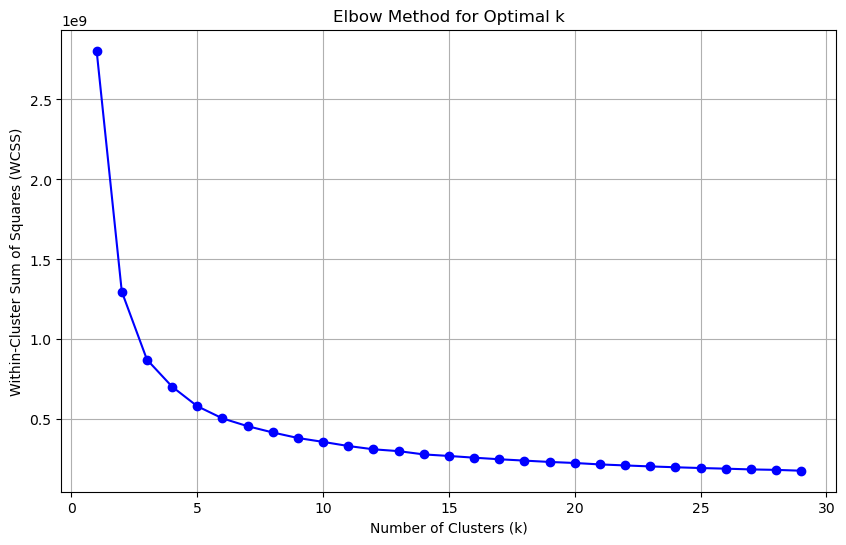

Optimal number of clusters: 13


In [31]:
# Parallel computation of WCSS
k_range = range(1, 30)  # Define the range of cluster counts to try
#num_cores = -1  # Use all available cores (-1)

# Define function to compute WCSS for a single value of k
def compute_wcss(k, data):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=1)
    kmeans.fit(data)
    #print(f'Cluster {k} processed')
    return kmeans.inertia_

num_cores = os.cpu_count() - 2  # Reserve 2 cores for the system
if num_cores < 1:
    num_cores = 1  # Ensure at least one core is used

wcss = Parallel(n_jobs=num_cores)(
    delayed(compute_wcss)(k, valid_pixels) for k in k_range
)

#print("WCSS for all cluster values:", wcss)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid()
plt.show()

# Determine optimal k (manual inspection or heuristic)
optimal_k = k_range[np.argmin(np.diff(wcss, 2)) + 1]  # Using the second derivative heuristic
print(f"Optimal number of clusters: {optimal_k}")


In [32]:
spectral_species_file = os.path.join(input_dir, "spectral_species.tif")

In [33]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
cluster_labels = kmeans.fit_predict(valid_pixels)

# Reshape clustered data back into spatial dimensions
cluster_image = np.full((rows, cols), -9999, dtype=int)  # Initialize with NaN
valid_indices = np.where(~np.isnan(pca_data_selection_2d).any(axis=1))[0]
cluster_image[np.unravel_index(valid_indices, (rows, cols))] = cluster_labels

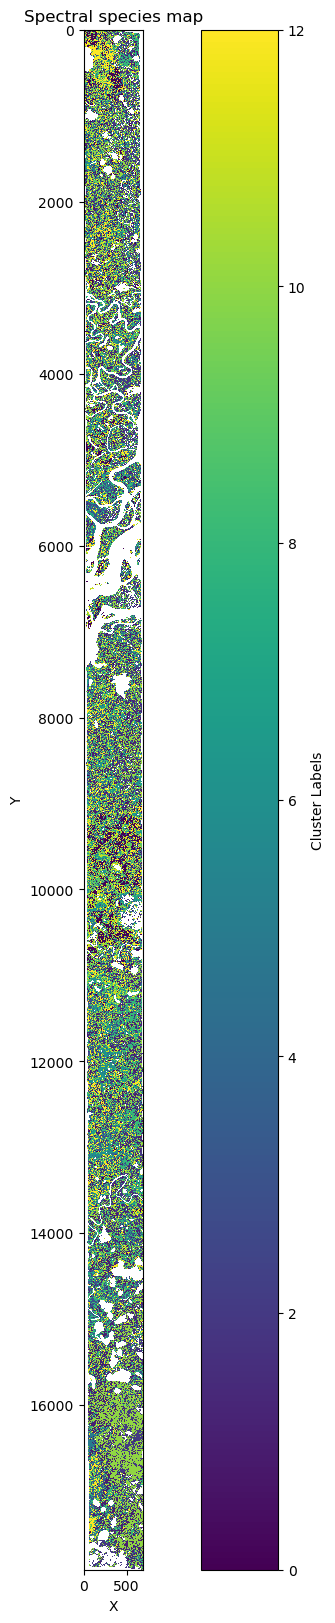

In [34]:
# Mask the no-data values (-9999)
masked_image = np.ma.masked_where(cluster_image == -9999, cluster_image)

# Plot the image with transparency for no-data values
plt.figure(figsize=(15, 20))
plt.imshow(masked_image, cmap='viridis', interpolation='none')  # interpolation='none' ensures no smoothing
plt.colorbar(label='Cluster Labels')
plt.title('Spectral species map')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [35]:
save_array(spectral_species_file, cluster_image, 1, img_open_pca_selection,"GTiff")
print(f'Spectral species file saved as {spectral_species_file}')

Spectral species file saved as ../aviris_data/e_done/e_ang20180722t212222rfl/data/hs_raw_image\spectral_species.tif


In [36]:
%reset -f

In [37]:
from pca_dataflow_V3_variables import *

In [38]:
output_cluster_file = os.path.join(input_dir, "spectral_species.tif")

In [39]:
# open the hyperspectral image file with GDAL
spectral_species_img = gdal.Open(output_cluster_file)

In [40]:
spectral_species_img_array = spectral_species_img.ReadAsArray()
print(spectral_species_img_array.shape)

(17913, 689)


In [41]:
# Mask no-data values (-9999) by excluding them
valid_pixels = spectral_species_img_array[spectral_species_img_array != -9999]

print("Valid pixels:", valid_pixels)

Valid pixels: [ 2. 10. 10. ...  2.  2.  2.]


In [42]:
# Calculate frequencies for valid clusters
unique, counts = np.unique(valid_pixels, return_counts=True)

# Convert to float for diversity calculations
counts = counts.astype(float)

print("Cluster frequencies:", counts)

Cluster frequencies: [ 588552. 1474290.  988653.  626783.   81432.  864549.  276664.  201214.
 1075481.  495561. 1676604.  275601.  894722.]


In [43]:
# Shannon diversity
shannon_index = alpha.shannon(counts)

# Simpson diversity
simpson_index = alpha.simpson(counts)

print(f"Shannon Index: {shannon_index}")
print(f"Simpson Index: {simpson_index}")

Shannon Index: 2.3489864879953335
Simpson Index: 0.8913076915690964


In [44]:
input_file = os.path.join(input_dir, "spectral_species.tif")
shannon_diversity_map_file = os.path.join(input_dir, "shannon_diversity_map.tif")  # Replace with desired output file path
window_size = 10  # Example window size

create_shannon_diversity_map(input_file, shannon_diversity_map_file, window_size)

Shannon diversity map saved to ../aviris_data/e_done/e_ang20180722t212222rfl/data/hs_raw_image\shannon_diversity_map.tif


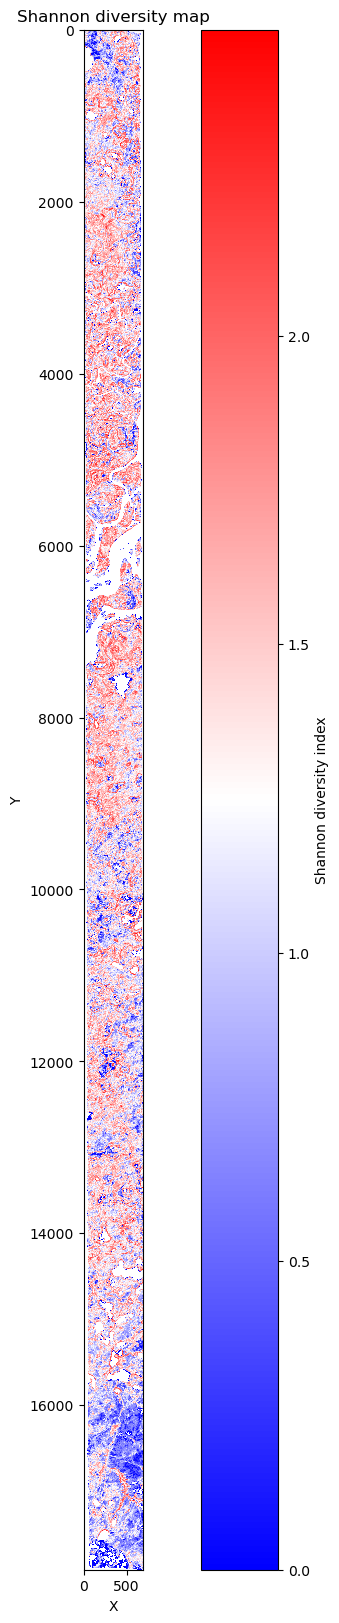

In [45]:
# Mask the no-data values (-9999)
shannon_diversity_map_data = gdal.Open(shannon_diversity_map_file).ReadAsArray()
shannon_diversity_map_data_masked_image = np.ma.masked_where(shannon_diversity_map_data == -9999, shannon_diversity_map_data)

# Plot the image with transparency for no-data values
plt.figure(figsize=(15, 20))
plt.imshow(shannon_diversity_map_data_masked_image, cmap='bwr', interpolation='none')  # interpolation='none' ensures no smoothing
plt.colorbar(label='Shannon diversity index')
plt.title('Shannon diversity map')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()